In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from utils import *
from metal.analysis import confusion_matrix
from metal.utils import convert_labels
from tagger import Tagger
import spacy

nlp = spacy.load("en_core_web_sm")

### Load Data

In [48]:
task_name = 'QNLI'
split = 'dev'
filepath = f'/dfs/scratch0/chami/metal/metal/mmtl/debugging/errors/03_16_19/{task_name}_{split}_error_analysis.tsv'
df_error = load_dataframe(filepath)

### View Errors

Plotting probabilities from the first column of Y_probs


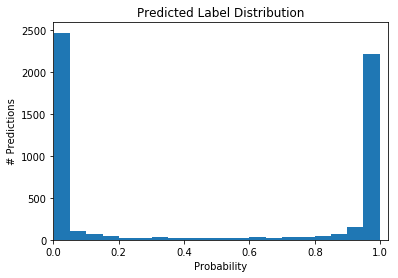

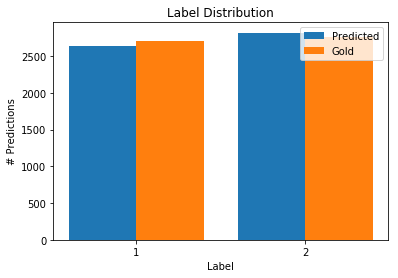

Plotting probabilities from the first column of Y_probs


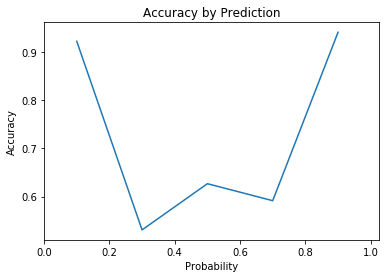

In [7]:
Y_gold = convert_labels(df_error['label'].values, "onezero", "categorical")
Y_preds = convert_labels(df_error['pred'].values, "onezero", "categorical")
Y_probs = np.vstack([df_error['score'].values, 1 - df_error['score'].values]).transpose()

from metal.contrib.visualization.analysis import (
        plot_predictions_histogram, 
        plot_probabilities_histogram,
        plot_calibration_plot
    )
plot_probabilities_histogram(Y_probs, title="Predicted Label Distribution")
plot_predictions_histogram(Y_preds, Y_gold, title="Label Distribution")
plot_calibration_plot(Y_probs, Y_gold, title="Accuracy by Prediction", bins=5)

In [51]:
# print("\033[1mBARELY RIGHT\033[0;0m")
# print_barely_right(df_error, thresh=0.4, n=10)
# print("\033[1mBARELY WRONG\033[0;0m")
# print_barely_wrong(df_error, thresh=0.2, n=1)
# print("\033[1mVERY WRONG\033[0;0m")
print_very_wrong(df_error, thresh=0, n=40)

475 matches were found with the given criteria.

sentence1: 	 What term do Islam ##ists think should be applied to them ? 
sentence2: 	 Islam ##ists have asked the question , " If Islam is a way of life , how can we say that those who want to live by its principles in legal , social , political , economic , and political spheres of life are not Muslims , but Islam ##ists and believe in Islam ##ism , not [ just ] Islam ? " 
score: 	0.0148
label: 	1

sentence1: 	 How is circuit switching ch ##are ##cter ##ized 
sentence2: 	 Pack ##et switching contrasts with another principal networking paradigm , circuit switching , a method which pre - all ##oc ##ates dedicated network bandwidth specifically for each communication session , each having a constant bit rate and late ##ncy between nodes . 
score: 	0.9907
label: 	2

sentence1: 	 What is the festival of food and drink known as ? 
sentence2: 	 EA ##T ! 
score: 	0.1047
label: 	1

sentence1: 	 What was the civil di ##so ##bedience performed at

In [49]:
i = np.random.randint(df_error.shape[0])
row = df_error.iloc[i]
print('sentence 1: ', row.sentence1.replace(" ##", ""))
print('sentence 2: ', str(row.sentence2).replace(" ##", ""))
print()
print('label: ', row.label)
print('score: ', row.score)

sentence 1:   who transported tesla ' s ashes from the us . 
sentence 2:   in 1957 , kosanovic ' s secretary charlotte muzar transported tesla ' s ashes from the united states to belgrade . 

label:  1
score:  0.9879273772239684


In [23]:
# tagger = Tagger(tags_dir='slices')
# tagger.get_examples('SST2_dev_while')

# Slicing

In [50]:
model_path = ''
task_name = 'QNLI'
split = 'dev'
# multi task
filepath = f'/dfs/scratch0/chami/metal/metal/mmtl/debugging/errors/03_16_19/{task_name}_cased_{split}_error_analysis.tsv'
# single task
# filepath = f'{task_name}_{split}_error_analysis.tsv'
print(filepath)
df_error = load_dataframe(filepath)
df_error.head()

/dfs/scratch0/chami/metal/metal/mmtl/debugging/errors/03_16_19/QNLI_cased_dev_error_analysis.tsv


,Unnamed: 0,sentence1,sentence2,score,label,pred,is_wrong
0,0,What came into force after the new constituti...,"As of that day , the new constitution her ##a...",0.022092,1,2,True
1,1,What is the first major city in the stream of...,The most important tributaries in this area a...,0.715851,2,1,True
2,2,What is the minimum required if you want to t...,In most provinces a second Bachelor ' s Degre...,0.872881,2,1,True
3,3,How was Te ##m ##ü ##jin kept imprisoned by t...,The Ta ##yi ##chi ' u ##d enslaved Te ##m ##ü...,0.866531,1,1,False
4,4,"What did Herr Got ##t , di ##ch lobe ##n w ##...","He para ##ph ##rase ##d the Te De ##um as "" H...",0.011868,2,2,False


In [48]:
from metal.mmtl.debugging.utils import print_row, apply_lfs_to_df, view_matches
from metal.mmtl.debugging.lf_helpers import regex_present
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
from slicing import *

df = df_error[['sentence1','sentence2']].apply(slice_morepeople, axis=1)

in_slice = df_error[df]
print(in_slice.head())

In [54]:
from slicing import *
    
df = df_error[['sentence1','sentence2']].apply(slice_who, axis=1)

in_slice = df_error[df]
print(in_slice.head())

from metal.analysis import confusion_matrix
from metal.utils import convert_labels

Y_gold = convert_labels(df_error['label'].values, "onezero", "categorical")
Y_preds = convert_labels(df_error['pred'].values, "onezero", "categorical")
Y_probs = np.vstack([df_error['score'].values, 1 - df_error['score'].values]).transpose()
print('IN ENTIRE {} DATASET'.format(task_name))

from metal.metrics import metric_score
metric_list = ['accuracy','precision', 'recall', 'f1']

for metric in metric_list:
    score = metric_score(Y_gold, Y_preds, metric, probs=Y_probs)
    print(f"{metric.capitalize()}: {score:.3f}")
print(f'There are {len(df_error)} examples in the dataset')
    
Y_gold = convert_labels(in_slice['label'].values, "onezero", "categorical")
Y_preds = convert_labels(in_slice['pred'].values, "onezero", "categorical")
Y_probs = np.vstack([in_slice['score'].values, 1 - in_slice['score'].values]).transpose()
print('\nIN SLICE')
    
from metal.metrics import metric_score
metric_list = ['accuracy','precision', 'recall', 'f1']

for metric in metric_list:
    score = metric_score(Y_gold, Y_preds, metric, probs=Y_probs)
    print(f"{metric.capitalize()}: {score:.3f}")
print(f'There are {len(in_slice)} examples in the slice')

   Unnamed: 0                                          sentence1  \
1           1   What is the first major city in the stream of...   
2           2   What is the minimum required if you want to t...   
3           3   How was Te ##m ##ü ##jin kept imprisoned by t...   
4           4   What did Herr Got ##t , di ##ch lobe ##n w ##...   
5           5   What year did the the case go before the supr...   

                                           sentence2     score  label  pred  \
1   The most important tributaries in this area a...  0.715851      2     1   
2   In most provinces a second Bachelor ' s Degre...  0.872881      2     1   
3   The Ta ##yi ##chi ' u ##d enslaved Te ##m ##ü...  0.866531      1     1   
4   He para ##ph ##rase ##d the Te De ##um as " H...  0.011868      2     2   
5   For example , Joseph Haas was arrested for al...  0.001374      2     2   

   is_wrong  
1      True  
2      True  
3     False  
4     False  
5     False  
IN ENTIRE QNLI DATASET
Accuracy:

In [12]:
# filename = f'slices/{task_name}_{split}_qualifiers.txt'
# print(in_slice)
# in_slice['uid'].to_csv(filename,sep='\t',header=False,index=False)

**1. Number Based LF**

Our model tends to fail when there are numbers involved in the two sentences. We can look for the same number being repeated in both sentences as an LF

**2. Edit Distance Based LF**

Our model tends to vote entailment when one sentence is long and the other is short. We can focus on this slice and flip the labelt o vote no entailment even when the number of words is the same.